# Absolute K Polarization Measurement

In [6]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.daq.nidaqmx_tools as ndaq
import one_ring.daq.stanford_research_systems as srs
import importlib
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
from scipy import constants
%matplotlib widget
import time as tm
import pyvisa as visa
import one_ring.daq.visa_instruments as nvisa
plt.style.use("dark_background")
import pandas as pd
import one_ring.daq.thorlabs as thor
import one_ring.daq.sacher_lasertechnik as sl

import one_ring.daq.tektronix as tek

In [7]:
from importlib import reload

In [14]:
#constants
bohr_magneton = constants.physical_constants['Bohr magneton'][0] * ureg.J/ureg.T
hbar = constants.hbar * ureg.J * ureg.s / ureg.rad
fg_calib = 100 * ureg.uT / (10*ureg.V)
Bz_calib = 0.2*ureg.uT/ureg.mA
g_factor_K = 0.5006
outfname = "C:/Users/labuser_L213/hybridpumping/data/hybrid_pumping.h5"

In [9]:
gyromagnetic_ratio_K = (bohr_magneton / hbar * g_factor_K).to(ureg.kHz/ureg.uT*ureg.rad)
gyromagnetic_ratio_K

<Quantity(44.0232649, 'kilohertz * radian / microtesla')>

In [10]:
def larmor(B):
    return (scipy.constants.physical_constants['electron gyromagn. ratio over 2 pi'][0] * ureg.MHz / ureg.T/ 4 * B).to(ureg.kHz)

def vapor_p_K(T):
    logp = 7.4077 - ureg.Quantity(4453,ureg.K) / T #nist, reports in mbar
    p = ureg.Quantity(10**logp, ureg.mbar)
    k_b = constants.physical_constants['Boltzmann constant'][0] * ureg.J / ureg.K
    n = p / k_b / T
    return n.to(ureg.cm**-3)

def LDC_transfer(I_set, V_mod):
    return I_set + V_mod * 500*ureg.mA / (10*ureg.V)

def LDC_AC(V_mod):
    return V_mod * 500*ureg.mA / (10*ureg.V)
    

In [11]:
LDC_AC(0.1*ureg.V) * Bz_calib 

<Quantity(1.0, 'microtesla')>

In [12]:
print('vapor pressure = {:.3e}'.format(vapor_p_K(354.2*ureg.K)))

vapor pressure = 1.401e+11 / centimeter ** 3


# Init Necessary Instruments

In [8]:
#list resources
rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR', 'ASRL4::INSTR')

In [9]:
#For DAQ finite measurement and unpacking measurements.
fs = 10 * ureg.Hz
dur = 2 * ureg.s
fm = ndaq.FiniteMeasurement(dur.m, (fs * dur).m, num_channels=1)

In [ ]:
#lock_in.close()

In [ ]:
#function generator
#func_gen = tek.AFG3251FunctionGenerator('USB0::0x0699::0x0353::2449628::INSTR')

In [ ]:
#thorlabs powermeter
pwr_mon = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0049964::INSTR')

In [ ]:
pwr_mon.wavelength = 421

In [ ]:
#lock in via ehternet
lock_in = srs.SRS860LockIn('169.254.59.121')

In [ ]:
#SRS860 Lock in via USB
#lock_in = srs.SRS860LockIn('USB0::0xB506::0x2000::005128::INSTR')

In [ ]:
Rb_laser = sl.PilotPCLaserController('ASRL4::INSTR')

In [ ]:
Rb_laser.query(':Piezo:ENA?')

In [ ]:
Rb_laser.write("system:echo off")
Rb_laser.write("system:acknowledge off")

In [ ]:
Rb_laser.inst.read()

# Lock-in Viewer (ETHERNET)

In [ ]:
#REQUIRES ETHERNET CONNECTION TO LOCK IN
fs = 200 * ureg.Hz
dt = 1/fs
LIV = srs.LockInViewer(lock_in, dt,channels='RT',width=15,height=7)

In [ ]:
LIV.display()

# PDB Monitor 

In [ ]:
PDB_Monitor.close()

In [11]:
fs = 100 * ureg.Hz #f3dB is 159kHz
dt = 1/fs
PDB_Monitor = ndaq.DAQViewer(dt,hw_buffer_size=10000, update_rate = 10)

In [12]:
PDB_Monitor.configure_channels()

In [13]:
PDB_Monitor.display()

Output()

In [ ]:
PDB_Monitor.get_data().mean()

# Spectrum Analyzer 

In [ ]:
SA.close()

In [ ]:
bw = 300 * ureg.kHz
fres = 1 * ureg.Hz
SA = ndaq.SpectrumAnalyzer(bw.to(ureg.Hz).m,fres.to(ureg.Hz).m)

In [ ]:
SA.configure_channels()

In [ ]:
SA.display()

In [ ]:
Z_AC_Field = SA.get_data().copy()['channel0'].to_numpy()

In [ ]:
f_test = SA.get_data()['channel0'].to_numpy()[209] * ureg.V / ureg.Hz**0.5 
f_test

In [ ]:
#estimating the Vamp of the test AC field
(((f_test * fg_calib)) * (1*ureg.Hz)**0.5 * (2)**0.5).to(ureg.uT)

# FG Monitoring / Magnetic Field Setting

In [ ]:
FG_Monitor.close()


In [ ]:
fs = 300 * ureg.Hz #f3dB is 159kHz
dt = 1/fs
FG_Monitor = ndaq.DAQViewer(dt,num_channels=3)

In [ ]:
FG_Monitor.configure_channels()

In [ ]:
FG_Monitor.display()

In [ ]:
#X Field (PROBE DIRECTION)
Bmag = FG_Monitor.get_data().mean().iloc[0] * ureg.V*fg_calib
Bmag.to(ureg.uT)

In [ ]:
#Y FIELD (PUMP DIRECTION)
print(FG_Monitor.get_data().mean().iloc[1]*ureg.V*fg_calib, larmor(FG_Monitor.get_data().mean().iloc[1]*ureg.V*fg_calib))
f0 = larmor(FG_Monitor.get_data().mean().iloc[1]*ureg.V*fg_calib)

In [ ]:
#Z Field (TRANSVERSE DIRECTION)
Bmag = FG_Monitor.get_data().mean().iloc[2] * ureg.V*fg_calib
Bmag.to(ureg.uT)

In [ ]:
#ac field is 1 uT in x direction rn 17/09/2025

# Test Magnetic Resonance Measurements

In [ ]:
def lock_in_measure():
    return lock_in.get_data(lock_in.Output.X, lock_in.Output.Y)

In [ ]:
#func_gen.close()

In [ ]:
#test getting data
X, Y = lock_in.get_data(lock_in.Output.X, lock_in.Output.Y)

In [ ]:
#expected larmor precession frequencyt
f0_exp = larmor(50*ureg.uT)

In [ ]:
#setting lock on frequecny to expectedv alue
func_gen.set_frequency(f0_exp)

In [ ]:
final_freq = 415 * ureg.kHz + 25 * ureg.kHz
initial_freq = 415 * ureg.kHz - 25* ureg.kHz
freq_step_size = 0.5*ureg.kHz
settle_time = 1*ureg.s

In [ ]:
(np.arange(initial_freq.to(ureg.Hz).m,final_freq.to(ureg.Hz).m,freq_step_size.to(ureg.Hz).m).size * settle_time).to(ureg.min)

In [ ]:
fscan, results_queue = func_gen.scan_frequency_and_measure(lock_in_measure,final_freq = final_freq,
                                                           freq_step_size = freq_step_size,
                                                           initial_freq = initial_freq,
                                                           initial_settle_time=1.5*ureg.s,
                                                           settle_time=settle_time,
                                                           )

In [ ]:
data= results_queue.get_nowait() 

In [ ]:
X, Y = fm.unpack_averaged_measurements(data)


In [ ]:
R = np.sqrt(X**2 + Y**2)

In [ ]:
abs_fitter = fitt.AbsorptiveLorentzianFitter()

In [ ]:
fit_result = abs_fitter.fit(fscan.m, R.m)

In [ ]:
func_gen.set_frequency(417.66 * ureg.kHz)

In [ ]:
(1.1 * ureg.V / (9.6*ureg.ohm) * Bz_calib).to(ureg.uT)

In [ ]:
fig, axes = plt.subplots(ncols=2,figsize=(18,6))
ax0, ax1 = axes
ax0.plot(fscan.m, X.m, color='C0',alpha=1)
ax0.plot(fscan.m, Y.m, color='C1',alpha=1)
ax1.plot(fscan.m, R.m, color='C0',alpha=1, label='Bz ~= 1.1Vpp or ~8nTp-p')


ax0.set_ylabel('Volts')
plt.title('Magnetic Resonance with different RF Kick Magnitude')
#ax0.legend()
ax1.legend()
plt.show()
fit_result.fit_parameters

In [ ]:
(700*ureg.mV * 500*ureg.mA / (10*ureg.V)).to(ureg.mA) 

In [ ]:
fig, axes = plt.subplots(ncols=2,figsize=(18,6))
ax0, ax1 = axes
ax0.plot(fscan.m, X.m, color='C0',alpha=1)
ax0.plot(fscan.m, Y.m, color='C1',alpha=1)
ax1.plot(fscan.m, R.m, color='C0',alpha=1, label='Bz ~= 400mVpp or ~8nTp-p')

ax0.plot(fscan.m, X1.m, color='C0',label='X')
ax0.plot(fscan.m, Y1.m, color='C1', label='Y')
ax1.plot(fscan.m, R1.m, color='C1', label='Bz ~= 600mVpp or ~12nTp-p')

ax0.plot(fscan.m, X2.m, color='C0',label='X')
ax0.plot(fscan.m, Y2.m, color='C1', label='Y')
ax1.plot(fscan.m, R2.m, color='C2', label='Bz ~= 1Vpp or ~20nTp-p')

ax0.plot(fscan.m, X5.m, color='C0',label='X')
ax0.plot(fscan.m, Y5.m, color='C1', label='Y')
ax1.plot(fscan.m, R5.m, color='C3', label='Bz ~= 6Vpp or ~119nTp-p')
fit_result3 = abs_fitter.fit(fscan.m, R5.m)
ax1.axvline(fit_result3.fit_parameters['f0'])


ax0.plot(fscan.m, X3.m, color='C0',label='X')
ax0.plot(fscan.m, Y3.m, color='C1', label='Y')
ax1.plot(fscan.m, R3.m, color='C4', label='Bz ~= 12Vpp or ~238nTp-p')
fit_result1 = abs_fitter.fit(fscan.m, R3.m)
ax1.axvline(fit_result1.fit_parameters['f0'])

ax0.plot(fscan.m, X4.m, color='C0',label='X')
ax0.plot(fscan.m, Y4.m, color='C1', label='Y')
ax1.plot(fscan.m, R4.m, color='C5', label='Bz ~= 17.744Vpp or ~354nTp-p')
fit_result2 = abs_fitter.fit(fscan.m, R4.m)
ax1.axvline(fit_result2.fit_parameters['f0'])


ax0.set_ylabel('Volts')
plt.title('Magnetic Resonance with different RF Kick Magnitude')
#ax0.legend()
ax1.legend()
plt.show()
fit_result.fit_parameters

In [ ]:
fit_result1.fit_parameters['f0']

In [ ]:
fit_result2.fit_parameters['f0']

In [ ]:
fit_result3.fit_parameters['f0']

In [ ]:
#data that shows that a change in voltage of the lab supply causes a change in the field resonance.
x = (np.array([1.948,2.015,2.147]) * ureg.V / (9.5*ureg.ohm) * Bz_calib).to(ureg.uT)
y = np.array([387.55753154156, 397.2023530093223, 416.9939251859587]) * ureg.kHz
fit_result = fitt.fit_line(x.m,y.m)
fit_result.fit_parameters

# Potassium Polarization Measurements via Adiabatic non-resonant Bx Modulation

## Methodology
pump direciton has 50uT, all else is 0uT in DC. But probe direciton has 1uT amplitude oscilation at f0 << larmor(50uT). (I usually did 210Hz). Then optimize pump temp and optics to maximize R for this given system. Probe temp can be sent -4.918 THz/HWHM off resonance (from probe 0.85degC calculation see K_Polarzation document). To Rb-laser calibration is  -28.09921442621999 gigahertz/delta_degree_Celsius


the laser piezo range was from -5 to 5 [-5, -4.98, -4.96...]

this translates to 0.5 to 99.5 [0.5, 0.7, 0.9, 1.1, 1.3...]

f0 occurs in the absorption profile at f0 = 710.9616495754816 * ureg.THz, this corresponds to setting the piezo voltage (before amplification) to 0.14762706197143416 volts.

the rb HWHM is 0.015336341358980104 THz

In [ ]:
pwr_mon.get_power()

In [ ]:
x = -4.918 * (0.015336341358980104*ureg.THz)
x #i want to be about 75GHz off resonance to have the same ratio.

This graph shows where we wanna be on the calibration curve
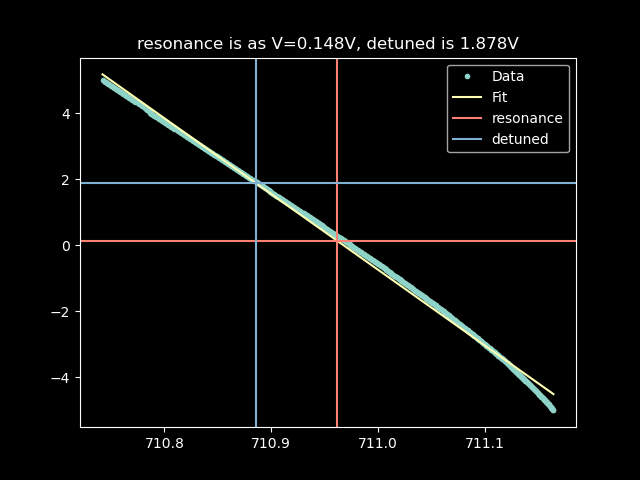

In [ ]:
Rb_laser.piezo_setpoint = 1.8776862013128266 #~68.6 on amplified version

In [ ]:
Rb_laser.piezo_setpoint = -0.2#this gives a better R though

In [ ]:
Rb_laser.piezo_setpoint

In [ ]:
pwr_mon.num_average = 100
pwr_mon.query('SENS:AVER:COUN?')
#here I am unable to figure out how to get uncertainties from the powermeter.

In [ ]:
#making independent measurements
tau = lock_in.time_constant
lock_in.filter_order
sample_rate = 152*ureg.Hz
indep_time = (10*tau).to(ureg.s)
mod_points = int(indep_time * sample_rate)

In [ ]:
#desired number of points 
num_points = 5
num_eff = int(num_points * mod_points)
num_eff

In [ ]:
time_est = num_eff/sample_rate
time_est

In [ ]:
#ONLY FOR FIRST DATA POINT\
x_arr_mes = data_temp[0][0]
y_arr_mes = data_temp[0][1]

In [ ]:
pump_pwr_arr_mes = np.array([]) * ureg.mW

In [ ]:
pump_pwr_arr_mes = np.append(pump_pwr_arr_mes, pwr_mon.get_power().to(ureg.mW))

In [ ]:
#taking other points

In [ ]:
pump_pwr_arr_mes = np.append(pump_pwr_arr_mes, pwr_mon.get_power().to(ureg.mW))

In [ ]:
#with a time constant of tau, every tau*10 s points are independent. So we will take one point every tau * 1 s.
out_queue = lock_in.capture(num_eff,channels='XY',sample_rate=152*ureg.Hz)

In [ ]:
data_temp = out_queue.get_nowait()

In [ ]:
x_arr_mes = np.vstack((x_arr_mes, data_temp[0][0]))
y_arr_mes = np.vstack((y_arr_mes, data_temp[0][1]))

In [ ]:
#check lengths
print(x_arr_mes.shape)
print(y_arr_mes.shape)
print(pump_pwr_arr_mes) 

In [ ]:
#extracting every 152nd point and then finding the mean and standard deviation.
skip_points = 152*3
x_mean = np.array([])
xerr_plot = np.array([])
for i in x_arr_mes:
    x_mean_i = i[::skip_points].mean()
    x_stdom_i = i[::skip_points].std(ddof=1) / np.sqrt(int(x_arr_mes.shape[1]/skip_points))
    x_mean = np.append(x_mean,x_mean_i)
    xerr_plot = np.append(xerr_plot,x_stdom_i)

y_mean = np.array([])
yerr_plot = np.array([])
for j in y_arr_mes:
    y_mean_j = j[::skip_points].mean()
    y_stdom_j = j[::skip_points].std(ddof=1) / np.sqrt(int(y_arr_mes.shape[1]/skip_points))
    y_mean = np.append(y_mean,y_mean_j)
    yerr_plot = np.append(yerr_plot,y_stdom_j)

R_estim = np.sqrt(x_mean**2 + y_mean**2)
R_err = np.abs(x_mean/R_estim)*xerr_plot + np.abs(y_mean/R_estim)*yerr_plot

fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax, ax1 = axes

#using instantiated data
ax.errorbar((pump_pwr_arr_mes).to(ureg.mW).m, R_estim.to(ureg.V).m, yerr = R_err / np.sqrt(y_arr_mes.shape[1]/mod_points))
pump_fitter = fitt.PolarizationPumpFitter()
fit_result = pump_fitter.fit(pump_pwr_arr_mes,R_estim.to(ureg.V).m,guess=np.array([0.5,150,1]))
fit_result.plot_fit(ax=ax,dkwargs={'label':'Datapoints'},fkwargs={'label':'Fitted Line'})

R_fit = fit_result.fit_parameters['R']
x_interp_arr = np.arange(1,R_fit.m,R_fit.m/100) * ureg.mW
ax1.plot(x_interp_arr, fit_result.polarization(x_interp_arr))

ax1.axvline(20,label='20mW Pump Power')
ax.set_title('Lock in output [V]')
ax1.set_title('Fitted Alkali Polarization')
ax.set_xlabel('Pump Power [mW]')
ax1.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Lock in output [V]')
ax1.set_ylabel('Interpolated Alkali Polarization')
ax1.legend()
plt.suptitle('Cell Olaf: Rubidium Polarization')
plt.tight_layout()
plt.show()

fit_result.fit_parameters

### Saving data

In [ ]:
#h5t.delete_dataset(outfname, grp_name)

In [ ]:
h5t.get_children('hybrid_pumping.h5', 'polarization_measurements/olaf_2025_09_09/190degC/rubidium_pol_1')

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "polarization_measurements/olaf_2025_09_17/190degC/rubidium_pol_1"
h5t.save_dataset(outfname, grp_name, "x", x_arr_mes)
h5t.save_dataset(outfname, grp_name, "y", y_arr_mes)
h5t.save_dataset(outfname, grp_name, "pump_pwr", pump_pwr_arr_mes)
metadata = {"probe_laser_current": 70*ureg.mA,
            "pump_laser_current": 120*ureg.mA,
            "pump_temp": ureg.Quantity(15.146, ureg.degC),
            "piezo_offset": 0.5,
            "probe_pwr_in": 0.00500936713 * ureg.W,
            "cell_temperature": ureg.Quantity(190, ureg.degC),
            "By_field": 51.36*ureg.uT,
            "Bx_field": -0.103*ureg.uT,
            "Bz_field": -0.186*ureg.uT,
            "Bx_field_AC_amp": 0.0992 * ureg.uT,
            "func_gen_amp": 500*ureg.mV,
            "Bx_ac_freq": 210*ureg.Hz,
            "mod_points": mod_points,
            "time_const": tau,
            "rot_calib": fit_result.fit_parameters,
            "misc_notes": "n.a"}
h5t.update_node_metadata(outfname, metadata, grp_name)

# Viewing Data

### With Wulfgang 26/08/2025

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))


#using loaded data
data150 = h5t.load_group(outfname, "polarization_measurements/wulfgang_2025_08_25/150degC/")
data100 = h5t.load_group(outfname, "polarization_measurements/wulfgang_2025_08_25/100degC/")
data80 = h5t.load_group(outfname, "polarization_measurements/wulfgang_2025_08_26/80degC/")

datasets = [data80, data100, data150]
labels= ['80 degC','100 degC', '150 degC']

for i,m in enumerate(datasets):
    data = m
    x_arr = data['x']
    y_arr = data['y']
    pump_pwr_arr = data['pump_pwr']
    R_arr = np.sqrt(x_arr**2 + y_arr**2)
    pump_fitter = fitt.PolarizationPumpFitter()
    fit_result = pump_fitter.fit(pump_pwr_arr,R_arr)

    x_interp_arr = np.arange(1,60,1) * ureg.mW
    ax.plot(x_interp_arr, fit_result.polarization(x_interp_arr),label=labels[i])

ax.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Alkali Polarization')
ax.legend()
plt.suptitle('Estimating Polarization')
plt.tight_layout()
plt.show()

## Olaf 26/08/2025

In [ ]:
LDC_AC(.1*ureg.V) * Bz_calib

In [ ]:
h5t.get_node_metadata(outfname, "polarization_measurements/olaf_2025_08_26/190degC/")

In [ ]:
fig, axes = plt.subplots(figsize=(14,6),ncols=2)

ax, ax1 = axes
#using loaded data

groups = ["polarization_measurements/olaf_2025_08_26/190degC/"]
labels= ['190 degC']

for i,m in enumerate(groups):
    data_test = h5t.load_group(outfname, groups[i])
    bs_calib = h5t.get_node_metadata(outfname, groups[i])["beam sampler ratio"]
    x_arr = data['x']
    y_arr = data['y']
    pump_pwr_arr = data['pump_pwr'] * bs_calib
    R_arr = np.sqrt(x_arr**2 + y_arr**2)
    
    pump_fitter = fitt.PolarizationPumpFitter()
    fit_result = pump_fitter.fit(pump_pwr_arr,R_arr)

    x_interp_arr = np.arange(1,fit_result.fit_parameters['R'].to(ureg.mW).m,1) * ureg.mW
    
    ax.plot(pump_pwr_arr, R_arr, label = labels[i])
    fit_result.plot_fit(ax=ax)
    ax1.plot(x_interp_arr, fit_result.polarization(x_interp_arr),label=labels[i])

ax.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Lock-In Output [V]')
ax1.set_ylabel('Alkali Polarization')
ax.legend()
ax1.legend()
plt.suptitle('Estimating Polarization')
plt.tight_layout()
plt.show()

In [ ]:
fit_result.fit_parameters

## Olaf 26/08/2025 K-Polarization

In [ ]:
fig, axes = plt.subplots(figsize=(14,6),ncols=2)

ax, ax1 = axes
#using loaded data

groups = ["polarization_measurements/olaf_2025_08_26/190degC/data_2"]
labels= ['190 degC']

for i,m in enumerate(groups):
    data = h5t.load_group(outfname, groups[i])
    bs_calib = h5t.get_node_metadata(outfname, groups[i])["beam sampler ratio"]
    x_arr = data['x']
    y_arr = data['y']
    pump_pwr_arr = data['pump_pwr'] * bs_calib
    R_arr = np.sqrt(x_arr**2 + y_arr**2)
    
    pump_fitter = fitt.PolarizationPumpFitter()
    fit_result = pump_fitter.fit(pump_pwr_arr,R_arr)

    x_interp_arr = np.arange(1,fit_result.fit_parameters['R'].to(ureg.mW).m,1) * ureg.mW
    
    ax.plot(pump_pwr_arr, R_arr, label = labels[i])
    fit_result.plot_fit(ax=ax)
    ax1.plot(x_interp_arr, fit_result.polarization(x_interp_arr),label=labels[i])

ax.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Lock-In Output [V]')
ax1.set_ylabel('Alkali Polarization')
ax.legend()
ax1.legend()
plt.suptitle('Estimating Polarization')
plt.tight_layout()
plt.show()


# Olaf 27/08/2025 polarization (good)

In [ ]:
#instantiation
data_loaded = h5t.load_group(outfname, "polarization_measurements/olaf_2025_08_27/190degC/potassium_pol_1")
x_load = data_loaded['x'].to(ureg.V)
y_load = data_loaded['y'].to(ureg.V)
pump_pwr_load = data_loaded['pump_pwr'].to(ureg.mW)
bs_ratio = h5t.get_node_metadata(outfname, "polarization_measurements/olaf_2025_08_27/190degC/potassium_pol_1")['beam sampler ratio']

In [ ]:
h5t.get_node_metadata(outfname, "polarization_measurements/olaf_2025_08_27/190degC/potassium_pol_1")

In [ ]:
x_load[i][::skip_points].shape

In [ ]:
#Formatting data so that I average time series after filtering for a point every 10 time constants. Also defining uncertainties for x and y.
skip_points = 152
x_mean = np.array([])
x_err = np.array([])
y_mean = np.array([])
y_err = np.array([])
N = int(x_load.shape[1]/skip_points)

for i in np.arange(0,x_load.shape[0]):
    x_mean = np.append( x_mean, x_load[i][::skip_points].mean())
    y_mean = np.append( y_mean, y_load[i][::skip_points].mean())
    x_err = np.append( x_err, x_load[i][::skip_points].std(ddof=1) / np.sqrt(N))
    y_err = np.append( y_err, y_load[i][::skip_points].std(ddof=1) / np.sqrt(N))

R_mean = np.sqrt(x_mean**2 + y_mean**2).to(ureg.V)
R_err = (x_mean/R_mean*x_err + y_mean/R_mean*y_err).to(ureg.V) #uncertianty propagation for correlated X and Y.

#PLOTTING
fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax, ax1 = axes

#fitting
pump_fitter = fitt.PolarizationPumpFitter()
fit_result = pump_fitter.fit( pump_pwr_load.m * bs_ratio, R_mean.m, guess=np.array([0.5,80,1]))

#plotting
ax.errorbar( pump_pwr_load.m * bs_ratio, R_mean.m, yerr = R_err.m)
fit_result.plot_fit(ax=ax,dkwargs={'label':'Datapoints'},fkwargs={'label':'Fitted Line'})

#interpolating a polarization curve using the relaxation fit parameters
R_fit = fit_result.fit_parameters['R'] 
x_interp_arr = np.arange(1,R_fit,R_fit/100) * ureg.mW
ax1.plot(x_interp_arr, fit_result.polarization(x_interp_arr.m),color='C1')

ax1.axvline(20,label='20mW Pump Power')
ax.set_title('Raw Measurements')
ax1.set_title('Estimating K-Polarization')
ax.set_xlabel('Pump Power [mW]')
ax1.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Lock in output [V]')
ax1.set_ylabel('Polarization')
ax1.legend()
plt.suptitle('Olaf K-Polarization 27/08/2025')
plt.tight_layout()
plt.show()

fit_result.fit_parameters

# Olaf 10/09/2025 polarization (best)

In [15]:
#instantiation
data_loaded = h5t.load_group(outfname, "polarization_measurements/olaf_2025_10_09/190degC/rubidium_pol_1")
x_load = data_loaded['x'].to(ureg.V)
y_load = data_loaded['y'].to(ureg.V)
pump_pwr_load = data_loaded['pump_pwr'].to(ureg.mW)

In [16]:
h5t.get_node_metadata(outfname, "polarization_measurements/olaf_2025_10_09/190degC/rubidium_pol_1")

{'beam sampler ratio': 0,
 'misc_notes': 'n.a',
 'mod_points': 1520,
 'Bx_ac_freq': <Quantity(210, 'hertz')>,
 'Bx_field': <Quantity(-0.154, 'microtesla')>,
 'Bx_field_AC_amp': <Quantity(0.0992, 'microtesla')>,
 'By_field': <Quantity(50.277, 'microtesla')>,
 'Bz_field': <Quantity(-0.343, 'microtesla')>,
 'cell_temperature': <Quantity(190, 'degree_Celsius')>,
 'func_gen_amp': <Quantity(500, 'millivolt')>,
 'piezo_offset': <Quantity(-0.2, 'volt')>,
 'probe_laser_current': <Quantity(70, 'milliampere')>,
 'pump_laser_current': <Quantity(120, 'milliampere')>,
 'pump_temp': <Quantity(15.146, 'degree_Celsius')>,
 'time_const': <Quantity(1, 'second')>}

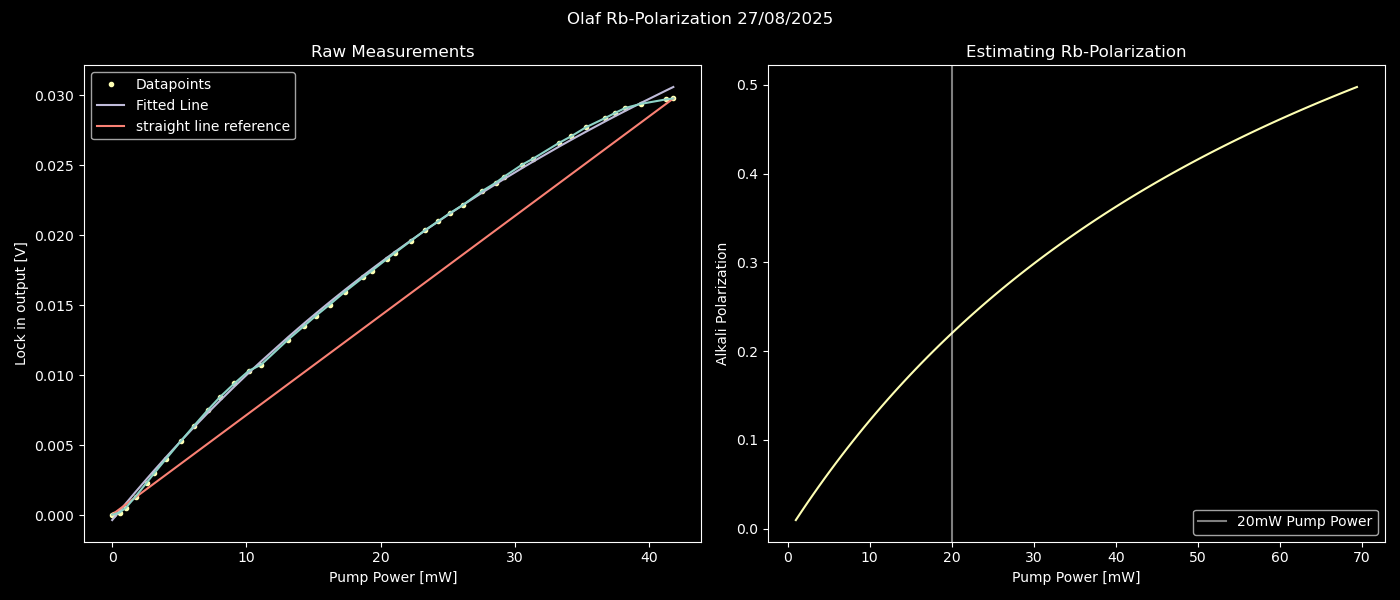

{'A': 0.08200874548031258, 'R': 69.78659717185703, 'R0': 0.3093179142119281}

In [18]:
#Formatting data so that I average time series after filtering for a point every 10 time constants. Also defining uncertainties for x and y.
skip_points = 152*3
x_mean = np.array([])
x_err = np.array([])
y_mean = np.array([])
y_err = np.array([])
N = int(x_load.shape[1]/skip_points)

for i in np.arange(0,x_load.shape[0]):
    x_mean = np.append( x_mean, x_load[i][::skip_points].mean())
    y_mean = np.append( y_mean, y_load[i][::skip_points].mean())
    x_err = np.append( x_err, x_load[i][::skip_points].std(ddof=1) / np.sqrt(N))
    y_err = np.append( y_err, y_load[i][::skip_points].std(ddof=1) / np.sqrt(N))

R_mean = np.sqrt(x_mean**2 + y_mean**2).to(ureg.V)
R_err = (x_mean/R_mean*x_err + y_mean/R_mean*y_err).to(ureg.V) #uncertianty propagation for correlated X and Y.

first_point_y = R_mean[0]
last_point_y = R_mean[-1]
first_point_x = pump_pwr_load[0]
last_point_x = pump_pwr_load[-1]

#PLOTTING
fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax, ax1 = axes

#fitting
pump_fitter = fitt.PolarizationPumpFitter()
fit_result = pump_fitter.fit( pump_pwr_load.m, R_mean.m, guess=np.array([0.5,80,1]))

#plotting
ax.errorbar( pump_pwr_load.m, R_mean.m, yerr = R_err.m)
fit_result.plot_fit(ax=ax,dkwargs={'label':'Datapoints'},fkwargs={'label':'Fitted Line'})
#plotting strait line for a reference
ax.plot(np.array([first_point_x.m,last_point_x.m]), np.array([first_point_y.m, last_point_y.m]), label='straight line reference')

#interpolating a polarization curve using the relaxation fit parameters
R_fit = fit_result.fit_parameters['R'] 
x_interp_arr = np.arange(1,R_fit,R_fit/100) * ureg.mW
ax1.plot(x_interp_arr, fit_result.polarization(x_interp_arr.m),color='C1')

ax.legend()
ax1.axvline(20,label='20mW Pump Power',alpha=0.5)
ax.set_title('Raw Measurements')
ax1.set_title('Estimating Rb-Polarization')
ax.set_xlabel('Pump Power [mW]')
ax1.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Lock in output [V]')
ax1.set_ylabel('Alkali Polarization')
ax1.legend()
plt.suptitle('Olaf Rb-Polarization 27/08/2025')
plt.tight_layout()
plt.show()

fit_result.fit_parameters

# Olaf rotation 17/09/2025

In [8]:
#instantiation
data_loaded = h5t.load_group(outfname, "polarization_measurements/olaf_2025_09_17/190degC/rubidium_pol_1")
x_load = data_loaded['x'].to(ureg.V)
y_load = data_loaded['y'].to(ureg.V)
pump_pwr_load = data_loaded['pump_pwr'].to(ureg.mW)

In [9]:
md_loaded = h5t.get_node_metadata(outfname, "polarization_measurements/olaf_2025_09_17/190degC/rubidium_pol_1")
md_loaded

{'misc_notes': 'n.a',
 'mod_points': 152,
 'piezo_offset': 0.5,
 'rot_calib': {'A': 0.30876860780269266,
  'R0': <Quantity(0.437828021, 'milliwatt')>,
  'R': <Quantity(205.113665, 'milliwatt')>},
 'Bx_ac_freq': <Quantity(210, 'hertz')>,
 'Bx_field': <Quantity(-0.103, 'microtesla')>,
 'Bx_field_AC_amp': <Quantity(0.0992, 'microtesla')>,
 'By_field': <Quantity(51.36, 'microtesla')>,
 'Bz_field': <Quantity(-0.186, 'microtesla')>,
 'cell_temperature': <Quantity(190, 'degree_Celsius')>,
 'func_gen_amp': <Quantity(500, 'millivolt')>,
 'probe_laser_current': <Quantity(70, 'milliampere')>,
 'probe_pwr_in': <Quantity(0.00500936713, 'watt')>,
 'pump_laser_current': <Quantity(120, 'milliampere')>,
 'pump_temp': <Quantity(15.146, 'degree_Celsius')>,
 'time_const': <Quantity(100, 'millisecond')>}

In [17]:
h5t.get_node_metadata(outfname, "polarization_measurements/olaf_2025_09_17/190degC/rubidium_pol_1")
c = scipy.constants.c * ureg.m/ureg.s
f_rb = 0.004 #5S1/2 to 6PS1/2
n_rb_olaf = (2.64e14 * ureg.cm**-3).to(ureg.m**-3)
rad_e = scipy.constants.physical_constants['classical electron radius'][0] * ureg.m
Lx = (10 * ureg.mm).to(ureg.m)
HWHM = 0.015336341358980104  *ureg.THz
tilt_theta = (np.arctan(md_loaded['Bx_field_AC_amp'] / md_loaded['By_field'])).to(ureg.deg)
Detune = (1/(2*HWHM)).to(ureg.s) #assuming detuning v-v_0 = HWHM which is optimal. 
#Not perfect assumption since when detuning blue lazer, power is also changing. hard to compare to absorption data because of drifting
#and not strong signal. In perfect scenario, we doo absorption immediately before polarization measurement so small drift.
rot_power_calib = 0.7262640373973412 * ureg.V / ureg.deg / ureg.mW
probe_pwr = md_loaded['probe_pwr_in']
rot_calib = (rot_power_calib * probe_pwr).to(ureg.volt/ureg.deg)
#rot_calib = {'slope': ureg.Quantity(1.09589413, 'volt / degree'),
# 'intercept': ureg.Quantity(-0.814997571, 'volt')}

In [18]:
1/2 * n_rb_olaf * rad_e * c * f_rb * tilt_theta * Lx * Detune

<Quantity(0.0160932369, 'degree')>

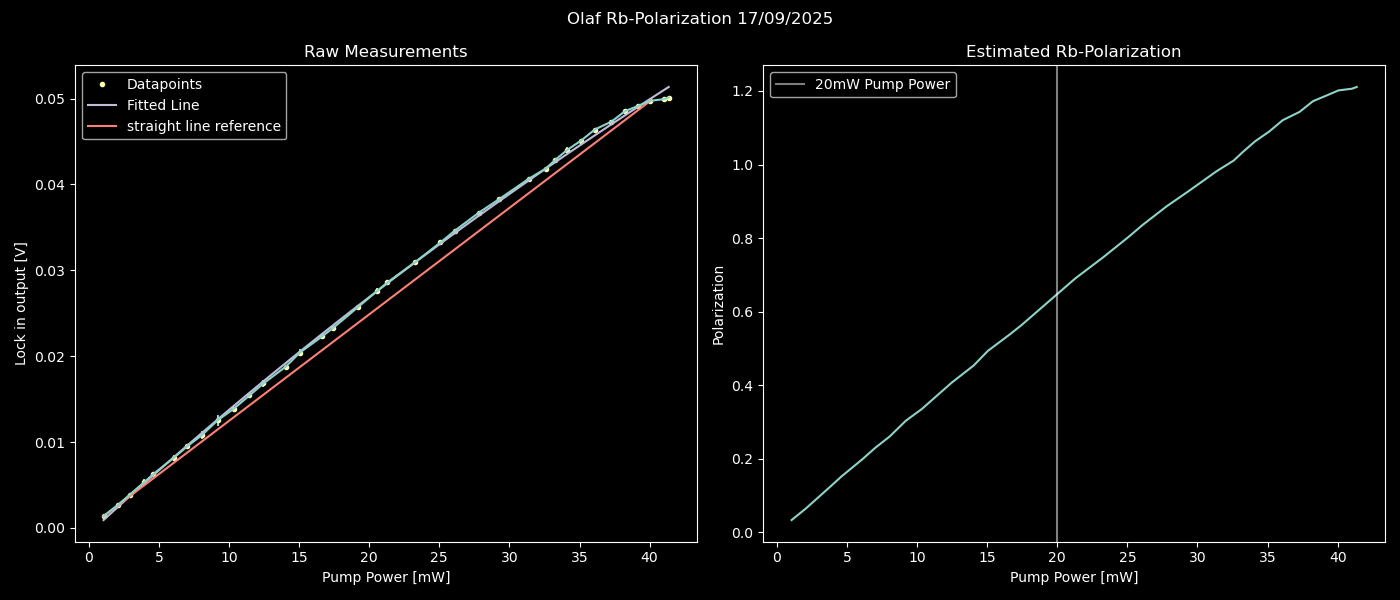

{'A': 0.30876879124035983, 'R': 205.11381119414904, 'R0': 0.43782729395904973}

In [20]:
#Formatting data so that I average time series after filtering for a point every 10 time constants. Also defining uncertainties for x and y.
skip_points = 152*3
x_mean = np.array([])
x_err = np.array([])
y_mean = np.array([])
y_err = np.array([])
N = int(x_load.shape[1]/skip_points)

for i in np.arange(0,x_load.shape[0]):
    x_mean = np.append( x_mean, x_load[i][::skip_points].mean())
    y_mean = np.append( y_mean, y_load[i][::skip_points].mean())
    x_err = np.append( x_err, x_load[i][::skip_points].std(ddof=1) / np.sqrt(N))
    y_err = np.append( y_err, y_load[i][::skip_points].std(ddof=1) / np.sqrt(N))

R_mean = np.sqrt(x_mean**2 + y_mean**2).to(ureg.V)
R_err = (np.abs(x_mean/R_mean)*x_err + np.abs(y_mean/R_mean)*y_err).to(ureg.V) #uncertianty propagation for correlated X and Y.

#calibration
Pz_estim = 2* R_mean * np.sqrt(2) / ( rot_calib * n_rb_olaf * c * Lx * Detune * tilt_theta * f_rb * rad_e)#.to(ureg.rad)

first_point_y = R_mean[0]
last_point_y = R_mean[-3]
first_point_x = pump_pwr_load[0]
last_point_x = pump_pwr_load[-3]

#PLOTTING
fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax, ax1 = axes

#fitting
pump_fitter = fitt.PolarizationPumpFitter()
fit_result = pump_fitter.fit( pump_pwr_load.m, R_mean.m, guess=np.array([0.5,80,1]))

#plotting
ax.errorbar( pump_pwr_load.m, R_mean.m, yerr = R_err.m)
fit_result.plot_fit(ax=ax,dkwargs={'label':'Datapoints'},fkwargs={'label':'Fitted Line'})
#plotting strait line for a reference
ax.plot(np.array([first_point_x.m,last_point_x.m]), np.array([first_point_y.m, last_point_y.m]), label='straight line reference')

#interpolating a polarization curve using the relaxation fit parameters
R_fit = fit_result.fit_parameters['R'] 
x_interp_arr = np.arange(1,R_fit,R_fit/100) * ureg.mW
#ax1.plot(x_interp_arr, fit_result.polarization(x_interp_arr.m),color='C1')
ax1.plot(pump_pwr_load.m, Pz_estim.m)

ax.legend()
ax1.axvline(20,label='20mW Pump Power',alpha=0.5)
ax.set_title('Raw Measurements')
ax1.set_title('Estimated Rb-Polarization')
ax.set_xlabel('Pump Power [mW]')
ax1.set_xlabel('Pump Power [mW]')
ax.set_ylabel('Lock in output [V]')
ax1.set_ylabel('Polarization')
ax1.legend()
plt.suptitle('Olaf Rb-Polarization 17/09/2025')
plt.tight_layout()
plt.show()

fit_result.fit_parameters

In [ ]:
y_err